In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import shutil
import numpy as np
import tensorflow as tf
print(tf.test.gpu_device_name())
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.applications import DenseNet121,InceptionV3
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

/device:GPU:0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Path to Images Dataset Images
Images_path_part1 = '/content/drive/MyDrive/Data/HAM10000_images_part_1'
Images_path_part2 = '/content/drive/MyDrive/Data/HAM10000_images_part_2'

# Path to All Images in Dataset
final_path = '/content/drive/MyDrive/Data/All_Images'

In [4]:
meta_data_df = pd.read_csv('/content/drive/MyDrive/Data/Updated_metadata.csv')
meta_data_df.sample(5)

,lesion_id,image_id,Diagnosis,Confirmation_Method,Age,Sex,Location,Image_path,Updated_Diagnosis_Label
7143,HAM_0002357,ISIC_0031783,bkl,histo,70,male,neck,/content/drive/MyDrive/Data/All_Images/ISIC_00...,2
4747,HAM_0000179,ISIC_0034046,mel,histo,45,male,back,/content/drive/MyDrive/Data/All_Images/ISIC_00...,4
4394,HAM_0002309,ISIC_0031910,nv,follow_up,25,male,trunk,/content/drive/MyDrive/Data/All_Images/ISIC_00...,5
3393,HAM_0001847,ISIC_0024792,mel,histo,50,male,back,/content/drive/MyDrive/Data/All_Images/ISIC_00...,4
7963,HAM_0005386,ISIC_0033505,bkl,histo,45,male,back,/content/drive/MyDrive/Data/All_Images/ISIC_00...,2


In [5]:
# Add Images' Path to Metadata
meta_data_df['Image_path'] = meta_data_df['image_id'].apply(lambda x: os.path.join(final_path, f"{x}.jpg"))
#Save Meta Data to new file
meta_data_df.to_csv('/content/drive/MyDrive/Data/Updated_metadata.csv',index=False)

In [6]:
meta_data_df

,lesion_id,image_id,Diagnosis,Confirmation_Method,Age,Sex,Location,Image_path,Updated_Diagnosis_Label
0,HAM_0007180,ISIC_0033272,mel,histo,65,male,face,/content/drive/MyDrive/Data/All_Images/ISIC_00...,4
1,HAM_0007195,ISIC_0031923,nv,histo,40,female,lower extremity,/content/drive/MyDrive/Data/All_Images/ISIC_00...,5
2,HAM_0001835,ISIC_0026652,mel,histo,65,male,back,/content/drive/MyDrive/Data/All_Images/ISIC_00...,4
3,HAM_0000465,ISIC_0030583,bkl,consensus,35,female,trunk,/content/drive/MyDrive/Data/All_Images/ISIC_00...,2
4,HAM_0001720,ISIC_0034010,nv,histo,45,male,abdomen,/content/drive/MyDrive/Data/All_Images/ISIC_00...,5
...,...,...,...,...,...,...,...,...,...
10010,HAM_0005460,ISIC_0028199,nv,follow_up,50,female,lower extremity,/content/drive/MyDrive/Data/All_Images/ISIC_00...,5
10011,HAM_0005615,ISIC_0031067,nv,follow_up,45,female,trunk,/content/drive/MyDrive/Data/All_Images/ISIC_00...,5
10012,HAM_0005773,ISIC_0031096,nv,follow_up,45,female,lower extremity,/content/drive/MyDrive/Data/All_Images/ISIC_00...,5
10013,HAM_0001053,ISIC_0030998,bkl,consensus,55,female,chest,/content/drive/MyDrive/Data/All_Images/ISIC_00...,2


In [7]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit LabelEncoder and transform 'Region_Of_Disease' column
meta_data_df['Updated_Diagnosis_Label'] = label_encoder.fit_transform(meta_data_df['Diagnosis'])

# Display the mapping between original labels and encoded labels
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Encoding Mapping:")
print(label_mapping)

Label Encoding Mapping:
{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [8]:
meta_data_df.sample(5)

,lesion_id,image_id,Diagnosis,Confirmation_Method,Age,Sex,Location,Image_path,Updated_Diagnosis_Label
4326,HAM_0003802,ISIC_0032308,mel,histo,75,male,face,/content/drive/MyDrive/Data/All_Images/ISIC_00...,4
9707,HAM_0003609,ISIC_0025729,nv,consensus,30,male,foot,/content/drive/MyDrive/Data/All_Images/ISIC_00...,5
9551,HAM_0002547,ISIC_0024394,nv,histo,20,female,back,/content/drive/MyDrive/Data/All_Images/ISIC_00...,5
9634,HAM_0003951,ISIC_0025555,nv,histo,35,female,abdomen,/content/drive/MyDrive/Data/All_Images/ISIC_00...,5
4715,HAM_0001733,ISIC_0028931,bkl,histo,70,male,lower extremity,/content/drive/MyDrive/Data/All_Images/ISIC_00...,2


# Base Model
This Model will be done without working on the Class Imbalance

In [9]:
# Shuffle Dataset
# Shuffle the dataset
meta_data_df = meta_data_df.sample(frac=1, random_state=42).reset_index(drop=True)
meta_data_df

,lesion_id,image_id,Diagnosis,Confirmation_Method,Age,Sex,Location,Image_path,Updated_Diagnosis_Label
0,HAM_0003445,ISIC_0026229,mel,histo,65,male,abdomen,/content/drive/MyDrive/Data/All_Images/ISIC_00...,4
1,HAM_0004434,ISIC_0024744,nv,follow_up,50,female,back,/content/drive/MyDrive/Data/All_Images/ISIC_00...,5
2,HAM_0005867,ISIC_0032387,nv,follow_up,65,female,trunk,/content/drive/MyDrive/Data/All_Images/ISIC_00...,5
3,HAM_0006679,ISIC_0031267,nv,follow_up,40,male,upper extremity,/content/drive/MyDrive/Data/All_Images/ISIC_00...,5
4,HAM_0006152,ISIC_0029571,mel,histo,55,female,upper extremity,/content/drive/MyDrive/Data/All_Images/ISIC_00...,4
...,...,...,...,...,...,...,...,...,...
10010,HAM_0005610,ISIC_0025312,bkl,confocal,65,female,face,/content/drive/MyDrive/Data/All_Images/ISIC_00...,2
10011,HAM_0004745,ISIC_0028004,nv,follow_up,60,male,trunk,/content/drive/MyDrive/Data/All_Images/ISIC_00...,5
10012,HAM_0004419,ISIC_0031331,nv,follow_up,50,female,trunk,/content/drive/MyDrive/Data/All_Images/ISIC_00...,5
10013,HAM_0003466,ISIC_0034132,mel,histo,70,female,lower extremity,/content/drive/MyDrive/Data/All_Images/ISIC_00...,4


In [10]:
# Separate features (X) and target variable (y)
X = meta_data_df.drop(columns=['Updated_Diagnosis_Label'])
y = meta_data_df['Updated_Diagnosis_Label']

# Display the shape of X and y
print("Shape of features (X):", X.shape)
print("Shape of target variable (y):", y.shape)

Shape of features (X): (10015, 8)
Shape of target variable (y): (10015,)


In [11]:
#train-test split without stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [12]:
# Data augmentation and generators
train_datagen = ImageDataGenerator(
rescale=1./255,
    brightness_range=[0.8, 1.2],
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=X_train,
    x_col='Image_path',
    y_col='Diagnosis',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = test_datagen.flow_from_dataframe(
    dataframe=X_val,
    x_col='Image_path',
    y_col='Diagnosis',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=X_test,
    x_col='Image_path',
    y_col='Diagnosis',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 5608 validated image filenames belonging to 7 classes.
Found 1402 validated image filenames belonging to 7 classes.
Found 3005 validated image filenames belonging to 7 classes.


In [13]:
# Load DenseNet121 pre-trained on ImageNet without the top layer , pooling='avg
base_model =DenseNet121(weights='imagenet',include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
predictions = Dense(7, activation='softmax')(x)

29084464/29084464 [==============================] - 0s 0us/step


In [14]:
# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

from keras.optimizers import Adam
# compile model
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
            metrics=['accuracy'])

In [15]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
# Define callbacks
checkpoint = ModelCheckpoint(filepath='model_weights.keras', monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [16]:
with tf.device('/device:GPU:0'):
  # Training the model
  history=model.fit(
      train_generator,
      epochs=19,
      batch_size=32,
      validation_data=val_generator,
      callbacks=[reduce_lr, early_stopping]
  )

Epoch 1/19
176/176 [==============================] - 2599s 15s/step - loss: 1.6364 - accuracy: 0.6960 - val_loss: 1.1333 - val_accuracy: 0.7033 - lr: 0.0010
Epoch 2/19
176/176 [==============================] - 124s 702ms/step - loss: 1.0032 - accuracy: 0.7150 - val_loss: 0.9813 - val_accuracy: 0.6976 - lr: 0.0010
Epoch 3/19
176/176 [==============================] - 125s 708ms/step - loss: 0.8950 - accuracy: 0.7295 - val_loss: 0.9137 - val_accuracy: 0.7126 - lr: 0.0010
Epoch 4/19
176/176 [==============================] - 125s 712ms/step - loss: 0.8356 - accuracy: 0.7402 - val_loss: 0.9028 - val_accuracy: 0.7068 - lr: 0.0010
Epoch 5/19
176/176 [==============================] - 126s 716ms/step - loss: 0.8078 - accuracy: 0.7409 - val_loss: 0.8457 - val_accuracy: 0.7190 - lr: 0.0010
Epoch 6/19
176/176 [==============================] - 123s 701ms/step - loss: 0.7930 - accuracy: 0.7466 - val_loss: 0.8503 - val_accuracy: 0.7204 - lr: 0.0010
Epoch 7/19
176/176 [===========================

> An accuracy of 77% indicates that the model performs quite well, despite the imbalance in classes. This suggests that our model is robust and effective in its predictions.

In [17]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score

# Predictions
predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

# Metrics
true_classes = test_generator.classes
accuracy = accuracy_score(true_classes, predicted_classes)
cm = confusion_matrix(true_classes, predicted_classes)
sensitivity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
specificity = cm[0, 0] / (cm[0, 1] + cm[0, 0])
report = classification_report(true_classes, predicted_classes, target_names=list(train_generator.class_indices.keys()), output_dict=True)
precision = report['macro avg']['precision']
f1_score = report['macro avg']['f1-score']
auc = roc_auc_score(tf.keras.utils.to_categorical(true_classes), predictions, multi_class='ovr')

print(f"Accuracy: {accuracy:.2f}")
print(f"Sensitivity: {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"Precision: {precision:.2f}")
print(f"F1-Score: {f1_score:.2f}")
print(f"AUC: {auc:.2f}")

94/94 [==============================] - 1127s 12s/step
Accuracy: 0.73
Sensitivity: 0.92
Specificity: 0.40
Precision: 0.55
F1-Score: 0.44
AUC: 0.90


> High accuracy (73%), but the specificity (40%) suggests it has more difficulty correctly identifying some classes compared to others classes  
> Precision (55%) indicates that when the model predicts a class, it is correct about 55% of the time.   
> The AUC score (0.90) is quite high, indicating that the model performs well in distinguishing between the classes.

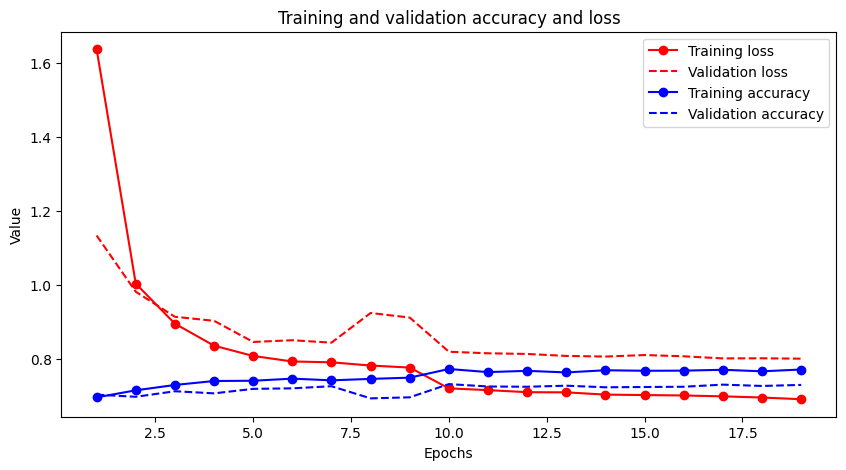

In [49]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Plot accuracy and loss on the same graph
plt.figure(figsize=(10, 5))

# Plot loss
plt.plot(epochs, loss, 'ro-', label='Training loss')
plt.plot(epochs, val_loss, 'r--', label='Validation loss')

# Plot accuracy
plt.plot(epochs, acc, 'bo-', label='Training accuracy')
plt.plot(epochs, val_acc, 'b--', label='Validation accuracy')

plt.title('Training and validation accuracy and loss')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()

plt.show()

In [50]:
model.outputs

[<KerasTensor: shape=(None, 7) dtype=float32 (created by layer 'dense_1')>]

In [53]:
from tensorflow.keras.models import save_model
save_model(model,'/content/drive/MyDrive/Data/DenseNet.h5')

In [52]:
import pickle
pickle.dump(model, open('/content/drive/MyDrive/Data/DenseNet.pkl','wb'))